# **Implementation of Convolutional Neral Networks (CCNs) - CNN and HAM10000 (Dermatology Images)**

**Introduction to Deep Learning (BioE 394E)**  
**Code by Ricardo Henao**  

> In this notebook, we are going to gain familiarity with the PyTorch deep learning framework by building PyTorch convolutional models to perform classification of dermatology images.

This notebook is a modified version of that in [Skin Lesion Classification - An Educational Guide](https://github.com/IFL-CAMP/SLClassificationAnEducationalCode-MEC2019)

## **0. Data required**

In this example we will be using a subset of the [HAMM10000](https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/DBW86T) dertmatology images dataset, so we are getting the images first.

In [ ]:
!gdown 1yn_YK8PFApDHaJ_QGUpyd9rouatsilpr
!unzip HAM10000_subset.zip

## **1. Setting Up the Enivronment**

### 1.1. Import utilities

First, we need to import necessary libraries, modules, and functions we'll use throughout this tutorial. We are mainly using functions from the [pytorch](https://pytorch.org/) library, which implements dataset instantiation, processing, data loader creation and model training.

In [1]:
import torch
from torch import nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import numpy as np
import pandas as pd
import os
import imageio
from scipy import stats
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
# Display GPU/CUDA availability
print('\nCUDA availability:  %s\n' % (torch.cuda.is_available()))


CUDA availability:  True



## **2. Loading and Preparing the Data**

One of the first (and often most important) steps in a machine learning pipeline is preparing the data. Here, we will load the subset of the HAM10000 dataset we just downloaded.

In [3]:
# importing metadata and checking for its shape
data_dir = "HAM10000_subset"

metadata = pd.read_csv('HAM10000_metadata.csv')

# label encoding the seven classes for skin cancers

le = LabelEncoder()
le.fit(metadata['dx'])
LabelEncoder()
print("Classes:", list(le.classes_))
 
metadata['label'] = le.transform(metadata["dx"]) 
metadata.sample(10)

Classes: ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']


,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset,label
5501,HAM_0003473,ISIC_0024417,nv,follow_up,75.0,male,trunk,vidir_molemax,5
5583,HAM_0001108,ISIC_0027313,nv,follow_up,75.0,male,lower extremity,vidir_molemax,5
2896,HAM_0005379,ISIC_0024787,bcc,histo,45.0,male,upper extremity,rosendahl,1
3219,HAM_0002651,ISIC_0028682,nv,follow_up,25.0,female,trunk,vidir_molemax,5
4204,HAM_0001408,ISIC_0031004,nv,follow_up,80.0,male,back,vidir_molemax,5
5271,HAM_0001252,ISIC_0026284,nv,follow_up,40.0,male,hand,vidir_molemax,5
5471,HAM_0005161,ISIC_0030472,nv,follow_up,65.0,male,trunk,vidir_molemax,5
531,HAM_0004143,ISIC_0029031,bkl,histo,50.0,male,chest,rosendahl,2
8577,HAM_0004824,ISIC_0026698,nv,histo,60.0,male,lower extremity,rosendahl,5
1960,HAM_0002834,ISIC_0026500,mel,histo,75.0,female,back,vienna_dias,4


## 2.1 Basic Dataset Characteristics

Below we summarize lesion type, sex, localization and age of the group of individuals in the dataset.

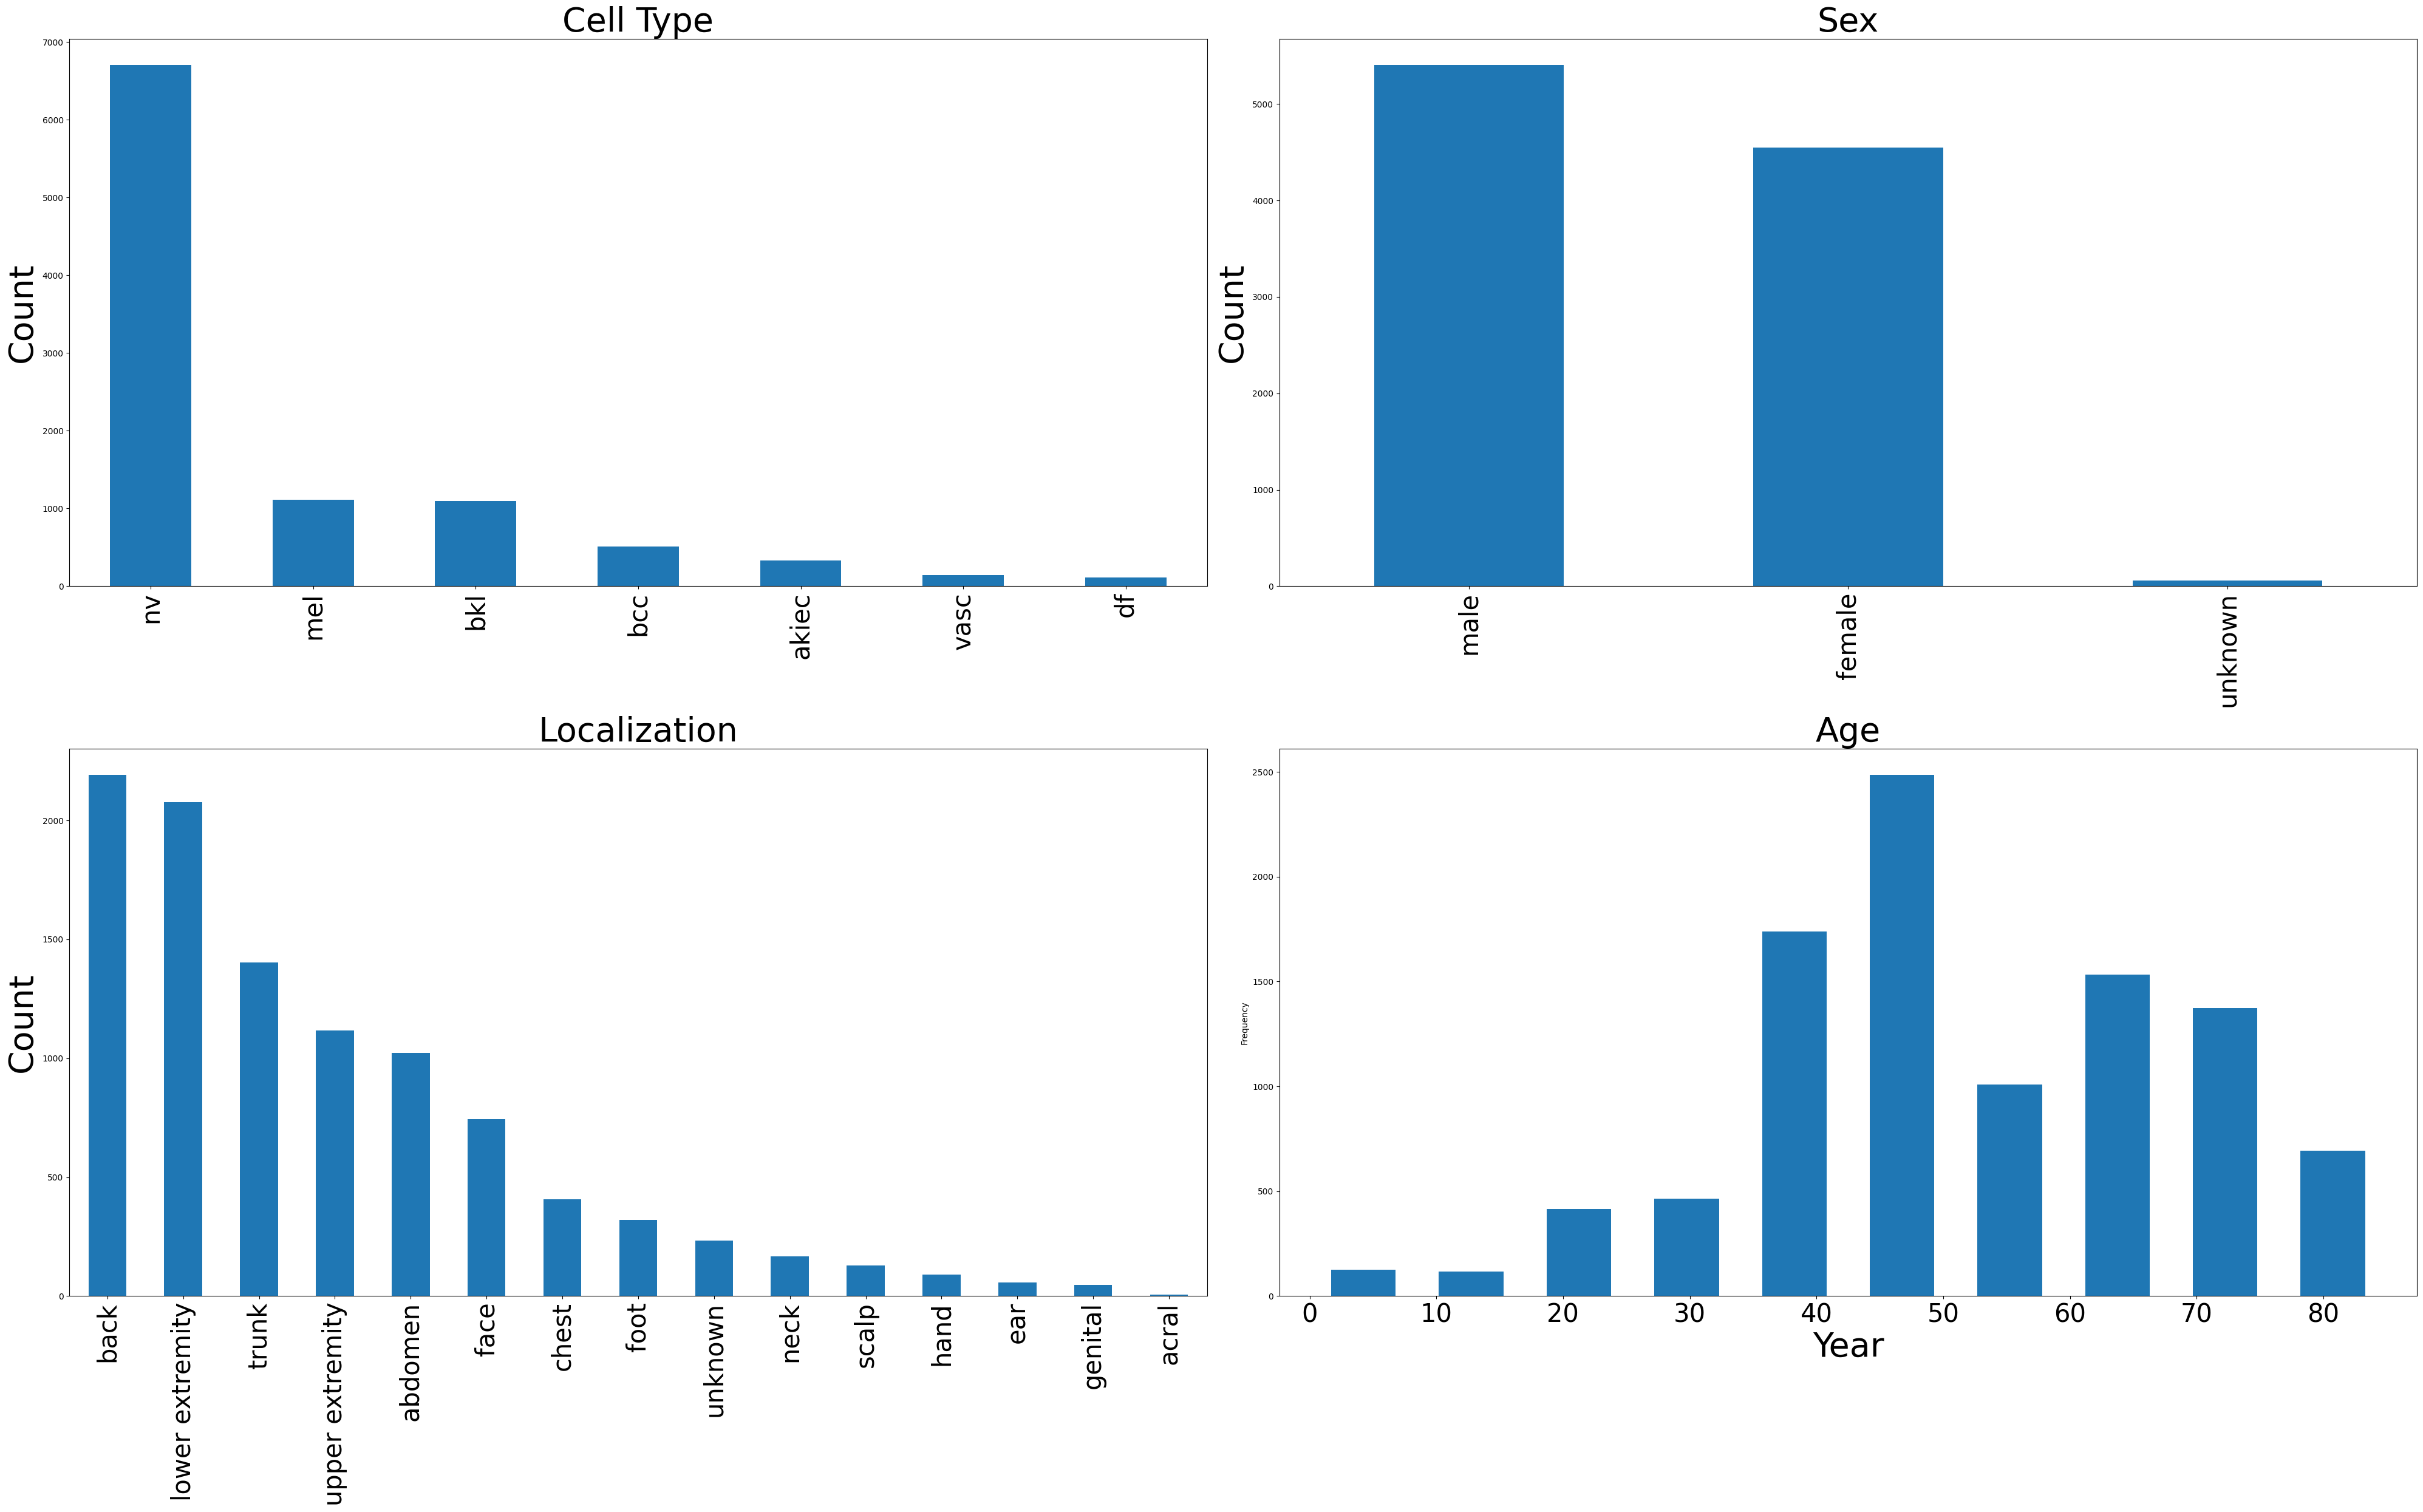

In [4]:
fig = plt.figure(figsize=(40,25))

ax1 = fig.add_subplot(221)
metadata['dx'].value_counts().plot(kind='bar', ax=ax1)
ax1.set_ylabel('Count', size=40)
ax1.set_title('Cell Type', size = 40)
plt.xticks(fontsize=30)

ax2 = fig.add_subplot(222)
metadata['sex'].value_counts().plot(kind='bar', ax=ax2)
ax2.set_ylabel('Count', size=40)
ax2.set_title('Sex', size=40)
plt.xticks(fontsize=30)

ax3 = fig.add_subplot(223)
metadata['localization'].value_counts().plot(kind='bar')
ax3.set_ylabel('Count', size=40)
ax3.set_title('Localization', size=40)
plt.xticks(fontsize=30)

ax4 = fig.add_subplot(224)
metadata['age'].plot( kind='hist', rwidth = 0.6 )
ax4.set_title('Age', size = 40)
ax4.set_xlabel('Year', size=40)
plt.xticks(fontsize=30)

plt.tight_layout()
plt.show()

## 2.2 Image Samples

Below we will see two examples of each lesion type. There are 7 lesion types being cobvered in the dataset.

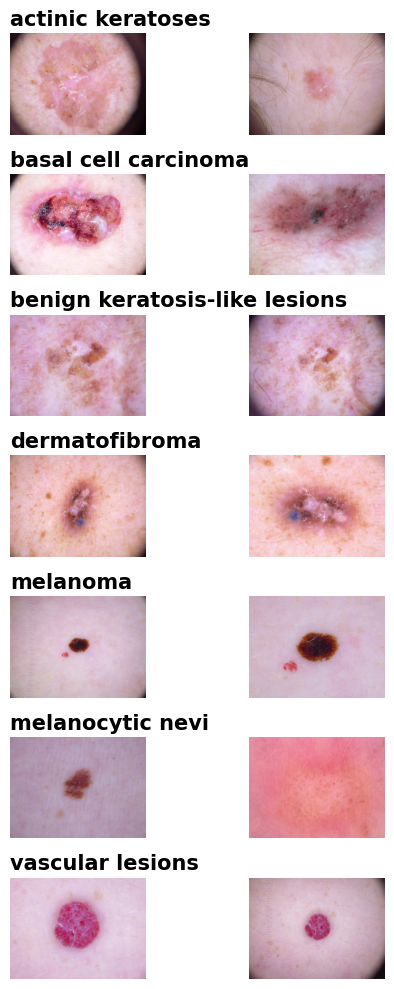

In [5]:
#Visualizing the images
label = [ 'akiec', 'bcc','bkl','df','mel', 'nv',  'vasc']
label_images = []
classes = [ 'actinic keratoses', 'basal cell carcinoma', 'benign keratosis-like lesions', 
           'dermatofibroma','melanoma', 'melanocytic nevi', 'vascular lesions']

fig = plt.figure(figsize=(5, 10))
k = range(7)

for i in label:
    sample = metadata[metadata['dx'] == i]['image_id'][:2]
    label_images.extend(sample)
    
for position,ID in enumerate(label_images):
    labl = metadata[metadata['image_id'] == ID]['dx']
    im_sample = data_dir + "/" + labl.values[0] + f'/{ID}.jpg'
    im_sample = imageio.v2.imread(im_sample)

    plt.subplot(7,2,position+1)
    plt.imshow(im_sample)
    plt.axis('off')

    if position%2 == 0:
        title = int(position/2)
        plt.title(classes[title], loc='left', size=15, weight="bold")

plt.tight_layout()
plt.show()

## 2.3 Preprocessing and Augmentation

Preprocessing: we will resize the images into 224x224 and normalize them to specific mean and standard deviation values to make them more comparable.

Augmentation: to artificially generate sample variation we will randomly flip and rotate images to make the model more robust to such variation.

In [6]:
data_dir = "HAM10000_subset"

# normalization values for pretrained resnet on Imagenet
norm_mean = (0.4914, 0.4822, 0.4465)
norm_std = (0.2023, 0.1994, 0.2010)

batch_size = 32
validation_batch_size = 16
test_batch_size = 16

# We compute the weights of individual classes and convert them to tensors
transform_train = transforms.Compose([
                    transforms.Resize((224,224)),
                    transforms.RandomHorizontalFlip(),
                    transforms.RandomRotation(degrees=60),
                    transforms.ToTensor(),
                    transforms.Normalize(norm_mean, norm_std),
                    ])

transform_test = transforms.Compose([
                    transforms.Resize((224,224)),
                    transforms.ToTensor(),
                    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
                    ])

## 2.4 Data Split

Below we split the entire dataset into training, validation and test sets. Sampling is done in a stratified fashion to account for class (lesion type) imbalance.

In [7]:
test_size = 0.2
val_size = 0.2

class Sampler(object):
    """Base class for all Samplers.
    """

    def __init__(self, data_source):
        pass

    def __iter__(self):
        raise NotImplementedError

    def __len__(self):
        raise NotImplementedError
        
class StratifiedSampler(Sampler):
    """Stratified Sampling
    Provides equal representation of target classes
    """
    def __init__(self, class_vector, test_size):
        """
        Arguments
        ---------
        class_vector : torch tensor
            a vector of class labels
        batch_size : integer
            batch_size
        """
        self.n_splits = 1
        self.class_vector = class_vector
        self.test_size = test_size

    def gen_sample_array(self):
        try:
            from sklearn.model_selection import StratifiedShuffleSplit
        except:
            print('Need scikit-learn for this functionality')
        import numpy as np
        
        s = StratifiedShuffleSplit(n_splits=self.n_splits, test_size=self.test_size)
        X = np.random.randn(self.class_vector.size(0),2)
        y = self.class_vector.numpy()
        s.get_n_splits(X, y)

        train_index, test_index= next(s.split(X, y))
        return train_index, test_index

    def __iter__(self):
        return iter(self.gen_sample_array())

    def __len__(self):
        return len(self.class_vector)
    

dataset = torchvision.datasets.ImageFolder(root= data_dir)
data_label = [s[1] for s in dataset.samples]

ss = StratifiedSampler(torch.FloatTensor(data_label), test_size)
pre_train_indices, test_indices = ss.gen_sample_array()
# The "pre" is necessary to use array to identify train/ val indices with indices generated by second sampler

train_label = np.delete(data_label, test_indices, None)
ss = StratifiedSampler(torch.FloatTensor(train_label), test_size)
train_indices, val_indices = ss.gen_sample_array()
indices = {'train': pre_train_indices[train_indices],  # Indices of second sampler are used on pre_train_indices
           'val': pre_train_indices[val_indices],  # Indices of second sampler are used on pre_train_indices
           'test': test_indices
           }

train_indices = indices['train']
val_indices = indices['val']
test_indices = indices['test']
print("Train Data Size:", len(train_indices))
print("Test Data Size:", len(test_indices))
print("Validation Data Size:", len(val_indices))

Train Data Size: 804
Test Data Size: 252
Validation Data Size: 201


In [8]:
SubsetRandomSampler = torch.utils.data.sampler.SubsetRandomSampler

dataset = torchvision.datasets.ImageFolder(root= data_dir, transform=transform_train)

train_samples = SubsetRandomSampler(train_indices)
val_samples = SubsetRandomSampler(val_indices)
test_samples = SubsetRandomSampler(test_indices)

train_data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False,num_workers=1, sampler= train_samples)
validation_data_loader = torch.utils.data.DataLoader(dataset, batch_size=validation_batch_size, shuffle=False, sampler=val_samples)

dataset = torchvision.datasets.ImageFolder(root= data_dir, transform=transform_test)
test_data_loader = torch.utils.data.DataLoader(dataset, batch_size=test_batch_size, shuffle=False, sampler=test_samples)

## 2.5 Visualizing Augmentations

Let us draw some images from the data loader to see how augmentations are manifested in the images that will be used for training.

(-0.5, 1809.5, 905.5, -0.5)

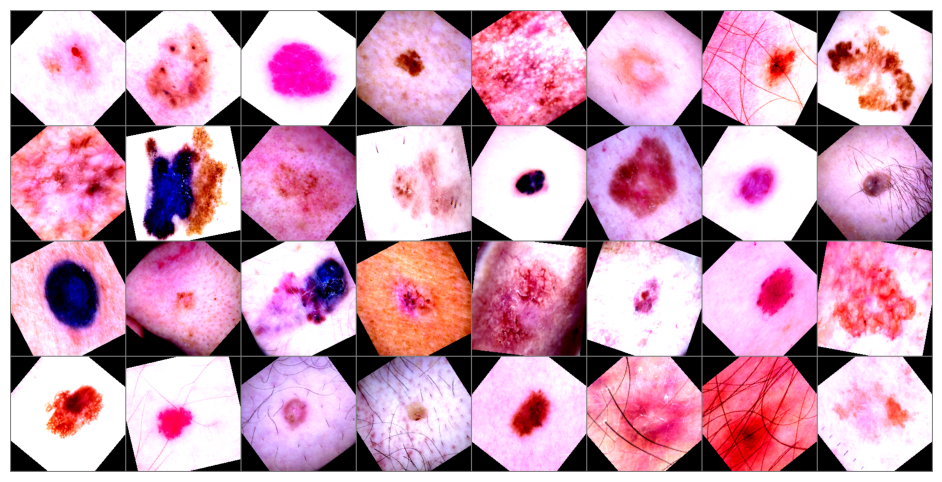

In [9]:
# functions to show an image
fig = plt.figure(figsize=(16, 6))
def imshow(img):
    img = img / 2 + 0.5     # denormalize change this
    img = np.clip( img, 0, 1 )
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(train_data_loader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
plt.axis('off')
# print labels
# print(' '.join('%5s, ' % classes[labels[j]] for j in range(len(labels))))

## 2.6 Basic CNN

As a starting point, we will define a simple convolutional neural network (CNN). This early CNN architecture is known as [LeNet](https://en.wikipedia.org/wiki/LeNet#:~:text=In%20general%2C%20LeNet%20refers%20to,in%20large%2Dscale%20image%20processing.).

In [10]:
num_classes = len(classes)

class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, (5,5), padding=2)
        self.conv2 = nn.Conv2d(6, 16, (5,5))
        self.fc1   = nn.Linear(16*54*54, 120)
        self.fc2   = nn.Linear(120, 84)
        self.fc3   = nn.Linear(84, num_classes)
    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2,2))
        x = F.max_pool2d(F.relu(self.conv2(x)), (2,2))
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    def num_flat_features(self, x):
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

net = LeNet()
net = net.to(device)

## 2.6 Setting loss, optmizer and metrics

below we set the optimization loss (cross-entropy), optimizer (Adam) and metrics (accuracy) used during training.

In [11]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)
print(net)

LeNet(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=46656, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=7, bias=True)
)


In [12]:
# number of parameters
total_params = sum(p.numel() for p in net.parameters())
print(f"Number of parameters: {total_params}")

Number of parameters: 5612471


In [13]:
from sklearn.metrics import accuracy_score

def get_accuracy(predicted, labels):
    batch_len, correct= 0, 0
    batch_len = labels.size(0)
    correct = (predicted == labels).sum().item()
    return batch_len, correct

def evaluate(model, val_loader):
    losses= 0
    num_samples_total=0
    correct_total=0
    model.eval()
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        out = model(inputs)
        _, predicted = torch.max(out, 1)
        loss = criterion(out, labels)
        losses += loss.item() 
        b_len, corr = get_accuracy(predicted, labels)
        num_samples_total +=b_len
        correct_total +=corr
    accuracy = correct_total/num_samples_total
    losses = losses/len(val_loader)
    return losses, accuracy

## 2.7 Model Training

We are training the model for 5 epochs using acuracy as the metric on the validation set to monitor convergence.

In [14]:
# number of loops over the dataset
num_epochs = 5
accuracy = []
val_accuracy = []
losses = []
val_losses = []


for epoch in range(num_epochs):
    running_loss = 0.0
    correct_total= 0.0
    num_samples_total=0.0
    for i, data in enumerate(train_data_loader):
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        # set the parameter gradients to zero
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        #compute accuracy
        _, predicted = torch.max(outputs, 1)
        b_len, corr = get_accuracy(predicted, labels)
        num_samples_total +=b_len
        correct_total +=corr
        running_loss += loss.item()

    
    running_loss /= len(train_data_loader)
    train_accuracy = correct_total/num_samples_total
    val_loss, val_acc = evaluate(net, validation_data_loader)
    
    print('Epoch: %d' %(epoch+1))
    print('Loss: %.3f  Accuracy:%.3f' %(running_loss, train_accuracy))
    print('Validation Loss: %.3f  Val Accuracy: %.3f' %(val_loss, val_acc))

    losses.append(running_loss)
    val_losses.append(val_loss)
    accuracy.append(train_accuracy)
    val_accuracy.append(val_acc)
print('Finished Training')

Epoch: 1
Loss: 1.749  Accuracy:0.306
Validation Loss: 1.544  Val Accuracy: 0.418
Epoch: 2
Loss: 1.528  Accuracy:0.433
Validation Loss: 1.462  Val Accuracy: 0.478
Epoch: 3
Loss: 1.414  Accuracy:0.442
Validation Loss: 1.483  Val Accuracy: 0.403
Epoch: 4
Loss: 1.325  Accuracy:0.495
Validation Loss: 1.306  Val Accuracy: 0.468
Epoch: 5
Loss: 1.162  Accuracy:0.535
Validation Loss: 1.280  Val Accuracy: 0.527
Finished Training


## 2.8 Model Evaluation

Performance on the validation and test sets will be evaluated in terms of accuracy. Further, we plot the accuracy during training and build a confusion matrix for a more granular characterization of the perfromance of the model.

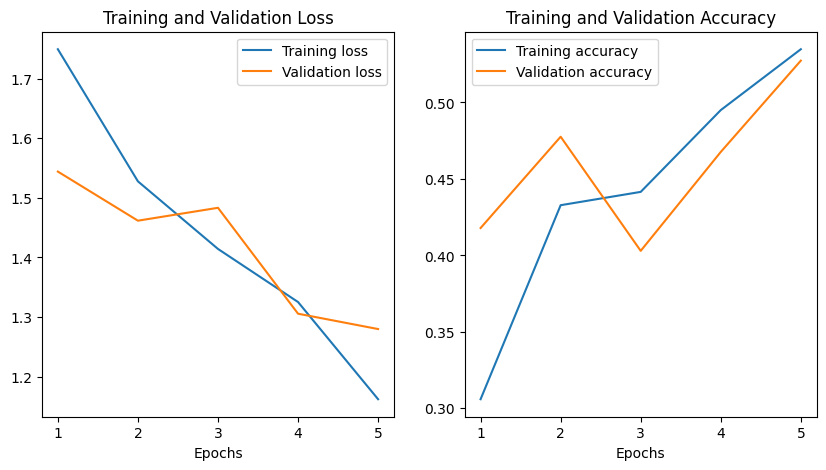

<Figure size 640x480 with 0 Axes>

In [15]:
epoch = range(1, num_epochs+1)
fig = plt.figure(figsize=(10, 5))

plt.subplot(1,2,1)
plt.plot(epoch, losses, label='Training loss')
plt.plot(epoch, val_losses, label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.legend()

plt.subplot(1,2,2)
plt.plot(epoch, accuracy, label='Training accuracy')
plt.plot(epoch, val_accuracy, label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.figure()
plt.show()

In [16]:
correct = 0
total = 0
net.eval()
with torch.no_grad():
    for data in test_data_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the test images: 47 %


In [17]:
confusion_matrix = torch.zeros(len(classes), len(classes))
with torch.no_grad():
    for data in test_data_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        for t, p in zip(labels.view(-1), predicted.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

cm = confusion_matrix.numpy()

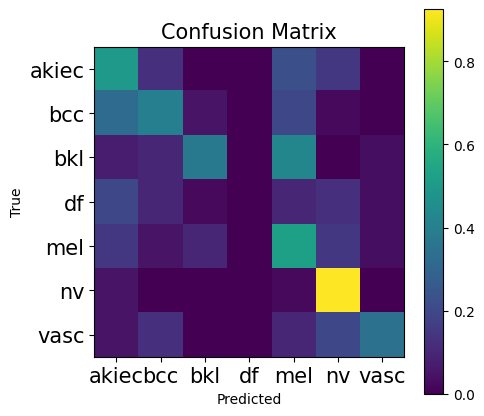

In [18]:
fig,ax= plt.subplots(figsize=(5,5))
plt.imshow( cm / (cm.astype(float).sum(axis=1) + 1e-9) )
plt.colorbar()

# labels, title and ticks
ax.set_xlabel('Predicted', size=10);
ax.set_ylabel('True', size=10); 
ax.set_title('Confusion Matrix', size=15); 
ax.set_yticks([0,1,2,3,4,5,6]);
ax.set_yticklabels(['akiec','bcc','bkl','df', 'mel', 'nv','vasc'], size=15);
ax.set_xticks([0,1,2,3,4,5,6]);
ax.set_xticklabels(['akiec','bcc','bkl','df','mel','nv','vasc'], size=15);

## 2.8 Transfer learning with ResNet

let us now use a more powerful CNN architecture called ResNet (with 18 layers), which has been pre-trained on the ImageNet dataset. Here we will be using transfer learning, *i.e.*, the convolutional encoder will remain fixed while we train the classification head.  

In [19]:
from torch import nn

num_classes = len(classes)
net = torchvision.models.resnet18(weights="IMAGENET1K_V1")
for param in net.parameters():
    param.requires_grad = False

# We replace last layer of resnet to match our number of classes which is 7
net.fc = nn.Linear(512, num_classes)
net = net.to(device)

In [20]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)
print(net)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [21]:
# number of parameters
total_params = sum(p.numel() for p in net.parameters())
print(f"Number of parameters: {total_params}")

Number of parameters: 11180103


In [24]:
from sklearn.metrics import accuracy_score

def get_accuracy(predicted, labels):
    batch_len, correct= 0, 0
    batch_len = labels.size(0)
    correct = (predicted == labels).sum().item()
    return batch_len, correct

def evaluate(model, val_loader):
    losses= 0
    num_samples_total=0
    correct_total=0
    model.eval()
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        out = model(inputs)
        _, predicted = torch.max(out, 1)
        loss = criterion(out, labels)
        losses += loss.item() 
        b_len, corr = get_accuracy(predicted, labels)
        num_samples_total +=b_len
        correct_total +=corr
    accuracy = correct_total/num_samples_total
    losses = losses/len(val_loader)
    return losses, accuracy

In [25]:
# number of loops over the dataset
num_epochs = 5
accuracy = []
val_accuracy = []
losses = []
val_losses = []


for epoch in range(num_epochs):
    running_loss = 0.0
    correct_total= 0.0
    num_samples_total=0.0
    for i, data in enumerate(train_data_loader):
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        # set the parameter gradients to zero
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        #compute accuracy
        _, predicted = torch.max(outputs, 1)
        b_len, corr = get_accuracy(predicted, labels)
        num_samples_total +=b_len
        correct_total +=corr
        running_loss += loss.item()

    
    running_loss /= len(train_data_loader)
    train_accuracy = correct_total/num_samples_total
    val_loss, val_acc = evaluate(net, validation_data_loader)
    
    print('Epoch: %d' %(epoch+1))
    print('Loss: %.3f  Accuracy:%.3f' %(running_loss, train_accuracy))
    print('Validation Loss: %.3f  Val Accuracy: %.3f' %(val_loss, val_acc))

    losses.append(running_loss)
    val_losses.append(val_loss)
    accuracy.append(train_accuracy)
    val_accuracy.append(val_acc)
print('Finished Training')

Epoch: 1
Loss: 1.849  Accuracy:0.261
Validation Loss: 1.646  Val Accuracy: 0.358
Epoch: 2
Loss: 1.530  Accuracy:0.479
Validation Loss: 1.428  Val Accuracy: 0.493
Epoch: 3
Loss: 1.343  Accuracy:0.526
Validation Loss: 1.335  Val Accuracy: 0.537
Epoch: 4
Loss: 1.224  Accuracy:0.581
Validation Loss: 1.239  Val Accuracy: 0.582
Epoch: 5
Loss: 1.103  Accuracy:0.648
Validation Loss: 1.160  Val Accuracy: 0.622
Finished Training


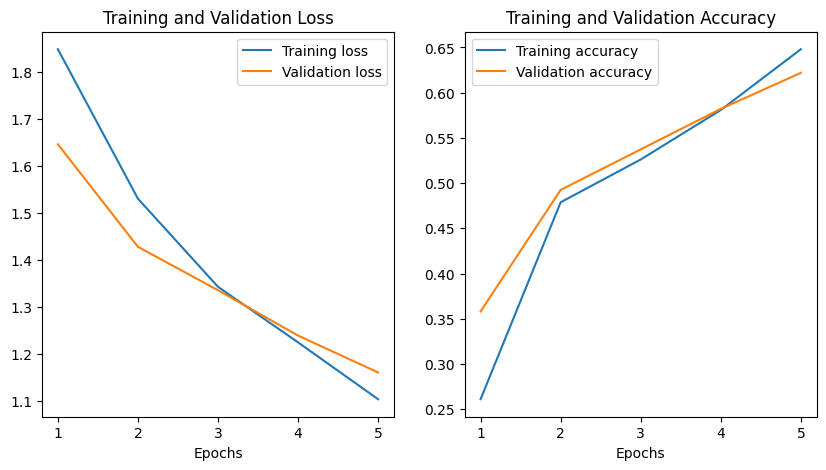

<Figure size 640x480 with 0 Axes>

In [26]:
epoch = range(1, num_epochs+1)
fig = plt.figure(figsize=(10, 5))

plt.subplot(1,2,1)
plt.plot(epoch, losses, label='Training loss')
plt.plot(epoch, val_losses, label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.legend()

plt.subplot(1,2,2)
plt.plot(epoch, accuracy, label='Training accuracy')
plt.plot(epoch, val_accuracy, label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.figure()
plt.show()

## 2.9 Saving and Loading

Once the model has been trained we can seve it for future use (commented line). Further, we can load a previously saved model into the ResNet architecture defined above.  

In [29]:
# torch.save( net.state_dict(), 'resnet_trained.pth' )
!wget https://raw.githubusercontent.com/rhenaog/kacademy_kacst_day12/main/checkpoints/resnet_trained.pth -P ./checkpoints
net.load_state_dict(torch.load('./checkpoints/resnet_trained.pth'))

--2023-10-01 04:58:54--  https://raw.githubusercontent.com/rhenaog/kacademy_kacst_day12/main/checkpoints/resnet_trained.pth
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 44797937 (43M) [application/octet-stream]
Saving to: ‘./checkpoints/resnet_trained.pth.4’

resnet_trained.pth. 100%[===================>]  42.72M  1.57MB/s    in 9.7s    

2023-10-01 04:59:04 (4.42 MB/s) - ‘./checkpoints/resnet_trained.pth.4’ saved [44797937/44797937]



<All keys matched successfully>

In [30]:
correct = 0
total = 0
net.eval()
with torch.no_grad():
    for data in test_data_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the test images: 66 %


In [31]:
confusion_matrix = torch.zeros(len(classes), len(classes))
with torch.no_grad():
    for data in test_data_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        for t, p in zip(labels.view(-1), predicted.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

cm = confusion_matrix.numpy()

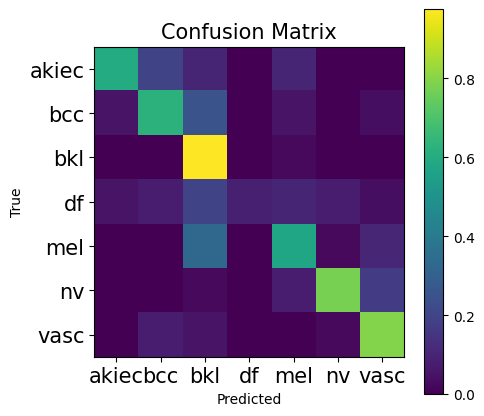

In [32]:
fig,ax= plt.subplots(figsize=(5,5))
# sns.heatmap(cm / (cm.astype(np.float).sum(axis=1) + 1e-9), annot=False, ax=ax)
plt.imshow( cm / (cm.astype(float).sum(axis=1) + 1e-9) )
plt.colorbar()

# labels, title and ticks
ax.set_xlabel('Predicted', size=10);
ax.set_ylabel('True', size=10); 
ax.set_title('Confusion Matrix', size=15); 
ax.set_yticks([0,1,2,3,4,5,6]);
ax.set_yticklabels(['akiec','bcc','bkl','df', 'mel', 'nv','vasc'], size=15);
ax.set_xticks([0,1,2,3,4,5,6]);
ax.set_xticklabels(['akiec','bcc','bkl','df','mel','nv','vasc'], size=15);